<a href="https://colab.research.google.com/github/Idriss-jedid/AI_Based_Data_Extraction_from_Reports/blob/main/AI_Based_Data_Extraction_from_Reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**T**his project is focused on extracting and analyzing data from blood analysis reports using advanced AI techniques, specifically leveraging the LayoutLMv3 model. The goal is to identify and extract key information from these reports, such as names and values, using natural language processing and computer vision methods.





This project utilizes the LayoutLMv3 model, a transformer-based architecture optimized for document understanding tasks, to process scanned reports in image format. By analyzing the layout of the document, the model is able to distinguish between various components such as text and graphical elements. The focus is primarily on extracting the name-value pairs from the report, which are key pieces of data in medical analysis.

Methodology:

**1** - Data Preparation: The data is pre-processed and cleaned into a format suitable for LayoutLMv3. This involves converting report data into JSON format, which includes text tokens, bounding boxes for each word, and the respective labels (e.g., 'name' or 'value').

**2** - Model Fine-Tuning: Using the fine-tuned LayoutLMv3 model for token classification, the project aims to predict entities like 'name' and 'value' from the report. The model is trained on a labeled dataset where words are classified into categories based on their context in the report.

**3** - OCR Integration: To handle any regions in the image that are not perfectly captured by the model, Optical Character Recognition (OCR) is used. The bounding boxes around text are extracted, and OCR is applied to these regions to retrieve any missing or unclear text.

**4** - Bounding Box Alignment: Each detected piece of text is associated with a bounding box to capture its position within the report. This enables the system to align extracted text with the respective labels (e.g., names, values) to understand their spatial relationship in the document.

**5** - Final Extraction: After processing the report with the model, the extracted names and values are compiled into a structured format, such as a JSON object, for further use or analysis.

In [1]:
!pip install datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports essential libraries including json, PIL, transformers, and datasets modules needed for the document analysis project.

In [1]:
import json
import os
from PIL import Image
import numpy as np
from transformers import LayoutLMv3ForTokenClassification, TrainingArguments, Trainer, default_data_collator, AutoProcessor
from datasets import Dataset, DatasetDict, Features, Sequence, Value, Array2D, Array3D
from datasets import load # Import load instead of load_metric

In [4]:
# Define paths
drive_path = '/content/drive/MyDrive'
njson1_folder = os.path.join(drive_path,'njson7')
cleaned_json_file = os.path.join(drive_path, 'testlayout7.json')

# Load the cleaned JSON file
with open(cleaned_json_file, 'r', encoding='utf-8') as file:
    data = json.load(file)

Creates a DatasetDict object containing document information including IDs, tokens, bounding boxes, NER tags, and image paths.

In [5]:
dataset = DatasetDict({
    'data': Dataset.from_dict({
        'id': [item['id'] for item in data],
        'tokens': [item['tokens'] for item in data],
        'bboxes': [item['bboxes'] for item in data],
        'ner_tags': [item['ner_tags'] for item in data],
        'image': [os.path.join(njson1_folder, item['image']) for item in data]
    })
})

In [25]:
dataset

DatasetDict({
    data: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 83
    })
})

In [6]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [32]:
sample = dataset['data'][0]
sample.keys()

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])

In [33]:
sample["tokens"]

['Globules rouge',
 'Hemoglobine',
 'Hematocrite',
 'VGM',
 'TGMH',
 'CCMH',
 'Globules blancs',
 'Neutrophiles',
 'Eosinophiles',
 'Basophiles',
 'Lymphocytes',
 'Monocytes',
 'Plaquettes',
 '5,30 10^6/mm^3',
 '15,80 g/100ml',
 '46,20%',
 '87,17 μ^3',
 '29,81 μμg',
 '34,20 g%',
 '6 200/mm3',
 '52%',
 '2%',
 '0%',
 '40%',
 '6%',
 '144,00 10^3/mm^3',
 'CRP(dosage)',
 '1,00 mg/l',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '..............................................................',
 '.............

In [34]:
sample['bboxes']

[[64, 407, 190, 420],
 [65, 425, 170, 437],
 [67, 443, 163, 455],
 [87, 460, 133, 473],
 [83, 481, 143, 493],
 [87, 497, 141, 513],
 [70, 518, 186, 530],
 [87, 551, 183, 565],
 [83, 571, 185, 582],
 [88, 586, 170, 601],
 [88, 606, 189, 622],
 [84, 624, 170, 637],
 [65, 641, 146, 654],
 [463, 403, 585, 421],
 [453, 425, 597, 438],
 [456, 443, 527, 456],
 [454, 460, 534, 476],
 [451, 479, 550, 496],
 [452, 500, 545, 514],
 [451, 517, 561, 532],
 [471, 550, 528, 564],
 [489, 571, 529, 582],
 [486, 585, 529, 599],
 [477, 604, 529, 618],
 [481, 622, 533, 636],
 [443, 641, 591, 654],
 [47, 714, 172, 732],
 [464, 714, 557, 732],
 [192, 407, 410, 422],
 [173, 428, 416, 440],
 [165, 447, 405, 459],
 [135, 465, 414, 476],
 [146, 485, 407, 493],
 [145, 503, 416, 513],
 [187, 521, 422, 532],
 [185, 557, 411, 566],
 [185, 574, 412, 585],
 [172, 594, 411, 600],
 [191, 609, 416, 619],
 [172, 629, 412, 635],
 [147, 646, 408, 653],
 [173, 721, 408, 729],
 [65, 534, 212, 548],
 [549, 548, 651, 563],
 [5

In [35]:
sample['ner_tags']

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [36]:
!pip install Pillow
from PIL import Image

In [37]:
sample['image']

'/content/drive/MyDrive/njson7/fa77da48-photo_340.jpg'

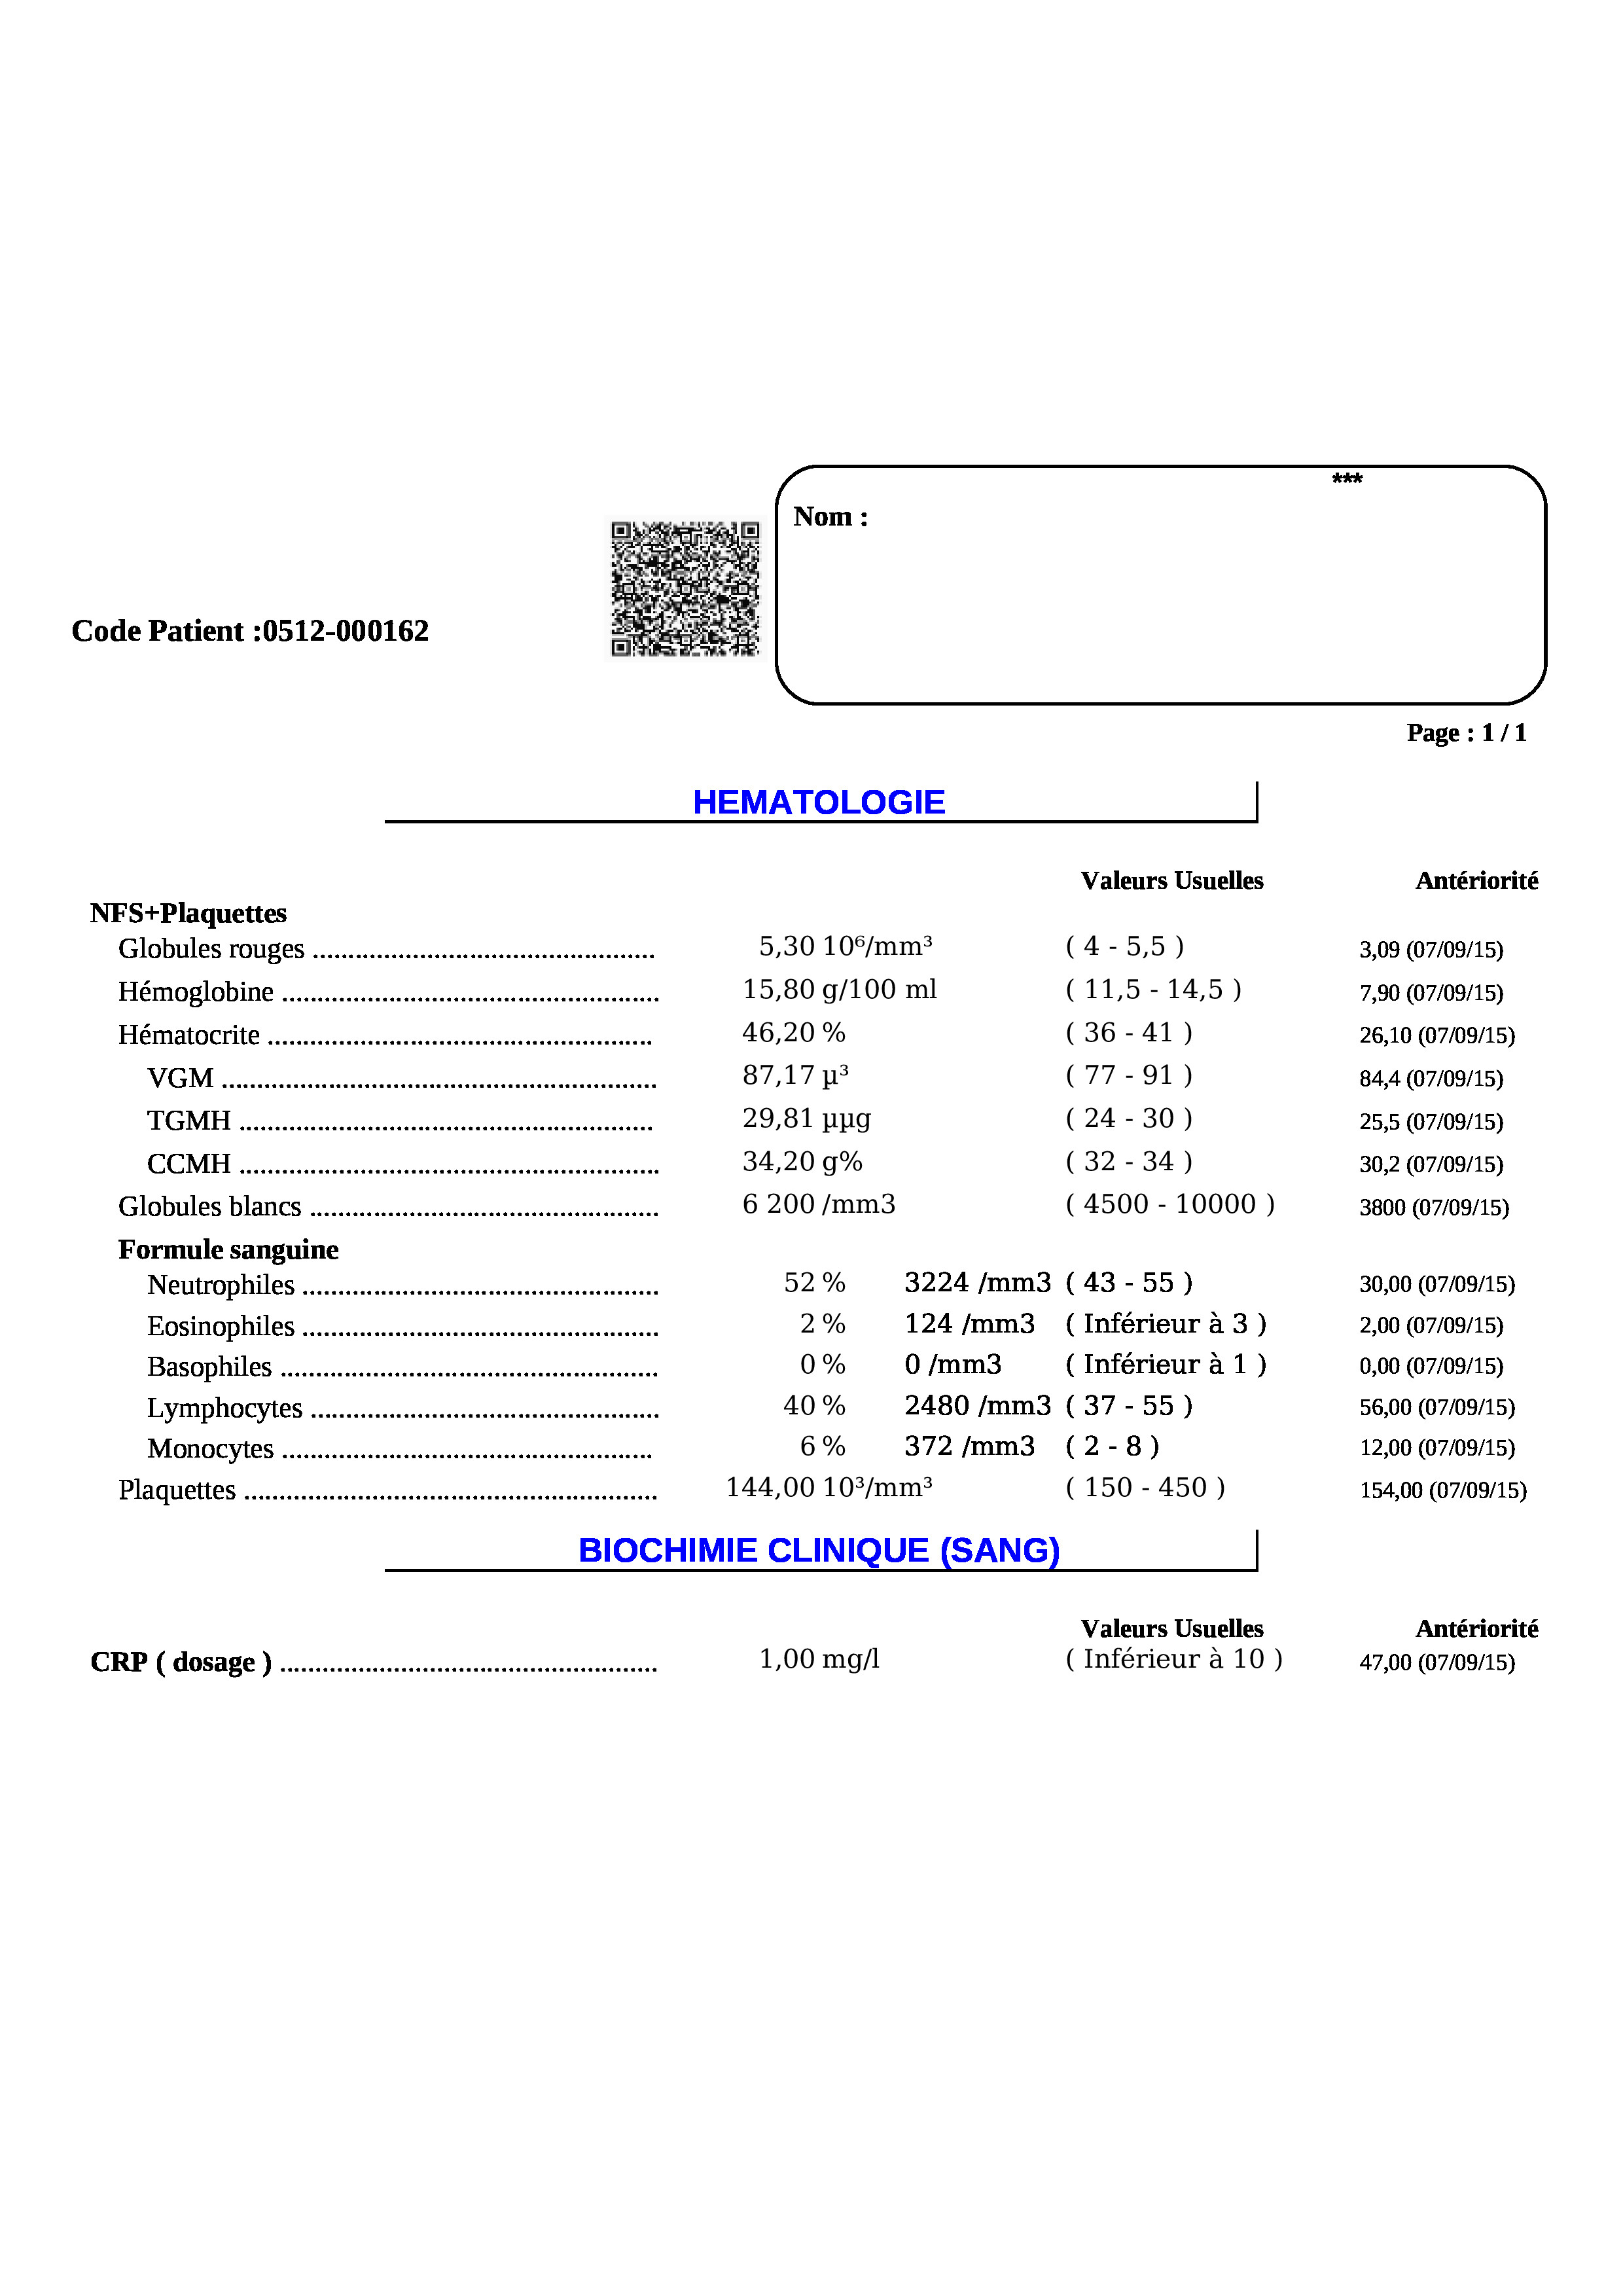

In [38]:
Image.open(sample['image']).convert("RGB")


In [39]:
words, boxes, ner_tags = sample["tokens"], sample["bboxes"], sample["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['Globules rouge', 'Hemoglobine', 'Hematocrite', 'VGM', 'TGMH', 'CCMH', 'Globules blancs', 'Neutrophiles', 'Eosinophiles', 'Basophiles', 'Lymphocytes', 'Monocytes', 'Plaquettes', '5,30 10^6/mm^3', '15,80 g/100ml', '46,20%', '87,17 μ^3', '29,81 μμg', '34,20 g%', '6 200/mm3', '52%', '2%', '0%', '40%', '6%', '144,00 10^3/mm^3', 'CRP(dosage)', '1,00 mg/l', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..............................................................', '..................................................


Defines the features structure for the dataset, including pixel values, input IDs, attention masks, bounding boxes, and labels.

In [7]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [8]:
# Train-test split
train_test_split = dataset['data'].train_test_split(test_size=0.24, shuffle=True, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [26]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 63
})

In [27]:
test_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 20
})

This function handles the crucial data preparation process. Let's break it down:

First, it loads and converts all images to RGB format using a list comprehension.

It extracts tokens (words), bounding boxes, and NER tags from the examples.

The function then filters examples to ensure words and boxes match in length.

Finally, it uses the processor to encode all the data into a format the model can understand
This preprocessing step is essential for maintaining data quality and ensuring consistent input format for the model.

In [9]:
def prepare_examples(examples):
    images = [Image.open(img_path).convert("RGB") for img_path in examples["image"]]
    words = examples["tokens"]
    bboxes = examples["bboxes"]
    word_labels = examples["ner_tags"]

    # Filter examples with matching words and boxes lengths
    filtered_examples = [
        (words_example, boxes_example, word_labels_example)
        for words_example, boxes_example, word_labels_example in zip(words, bboxes, word_labels)
        if len(words_example) == len(boxes_example)
    ]

    filtered_words, filtered_bboxes, filtered_word_labels = zip(*filtered_examples)

    # Convert filtered_words to a list before passing it to the processor
    encoding = processor(images, list(filtered_words), boxes=filtered_bboxes, word_labels=filtered_word_labels, truncation=True, padding="max_length")

    return encoding

In [10]:
train_dataset = train_dataset.map(
    prepare_examples,
    batched=True,
    remove_columns=train_dataset.column_names,
    features=features,
)

test_dataset = test_dataset.map(
    prepare_examples,
    batched=True,
    remove_columns=test_dataset.column_names,
    features=features,
)

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [11]:
id2label = {0: 'other', 1: 'name', 2: 'value'}
label2id = {'other': 0, 'name': 1, 'value': 2}

In [12]:
!pip install datasets evaluate transformers[torch] accelerate

In [13]:
!pip install -q evaluate
!pip install seqeval
import evaluate

metric = evaluate.load("seqeval")

label_list=['name','value','other']
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (-100) and map to labels
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


This configuration block sets up crucial hyperparameters for training:

The learning rate (1e-5) is carefully chosen to be small enough for fine-tuning .

Batch sizes are set to 8 to balance between memory usage and training speed .

Weight decay (0.05) helps prevent overfitting by penalizing large weights .

The cosine learning rate scheduler gradually reduces the learning rate .

Early stopping is implemented with a patience of 3 epochs to prevent overfitting.


In [21]:
# Initialize model and training arguments
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Updated training arguments
training_args = TrainingArguments(
    output_dir="./layoutlmv3_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-5,  # Reduced learning rate
    per_device_train_batch_size=8,  # Increased batch size
    per_device_eval_batch_size=8,  # Increased batch size
    num_train_epochs=10,
    weight_decay=0.05,  # Increased weight decay to prevent overfitting
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # Disable W&B logging
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",
)

# Updated EarlyStoppingCallback with lower patience
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Reduced patience from 5 to 3
)



Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
os.environ["WANDB_MODE"] = "disabled"
import warnings
warnings.simplefilter("ignore", UserWarning)



In [23]:
# Train the model
trainer.train()

# Evaluate the trained model
evaluation_result = trainer.evaluate()
print(evaluation_result)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.400584,0.241758,0.349206,0.285714,0.922046
2,0.668700,0.151101,0.693333,0.825397,0.753623,0.981730
3,0.237300,0.061945,0.892308,0.920635,0.906250,0.990256
4,0.074500,0.041023,0.937500,0.952381,0.944882,0.992692
5,0.039400,0.035874,0.937500,0.952381,0.944882,0.992692
6,0.039400,0.034903,0.937500,0.952381,0.944882,0.992692


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

{'eval_loss': 0.04102296009659767, 'eval_precision': 0.9375, 'eval_recall': 0.9523809523809523, 'eval_f1': 0.9448818897637795, 'eval_accuracy': 0.9926918392204629, 'eval_runtime': 2.5247, 'eval_samples_per_second': 7.922, 'eval_steps_per_second': 1.188, 'epoch': 6.0}


In [ ]:
# Save the trained model
model.save_pretrained('/content/drive/MyDrive/layoutlmv3-finetuned-custom1')

# Save the processor used for preprocessing (such as tokenization and image processing)
processor.save_pretrained('/content/drive/MyDrive/layoutlmv3-finetuned-custom_process1')


In [3]:
"""So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):"""

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


In [4]:
id2label = {0:'other',1: 'name', 2: 'value'}
label2id = {'other' :0,'name': 1, 'value': 2}

In [5]:
!pip install pytesseract
!sudo apt install tesseract-ocr
!apt-get update
!apt-get install -y tesseract-ocr libtesseract-dev
!pip install -q transformers
import pytesseract
from transformers import LayoutLMv3Processor, LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3ForTokenClassification, AutoProcessor
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured f

This section implements critical helper functions for the inference pipeline:

1 - The OCR function handles text extraction:

  Crops the image to the specified box region.

  Uses Tesseract OCR with PSM 6 mode (assume uniform text block).

  Strips whitespace from the extracted text.



2 -The box proximity checker:

Calculates center points of both boxes.

Uses Euclidean distance to determine if boxes are near each other.

Helps prevent duplicate detections of the same text region .

In [6]:
import json
# Load the model and processor
model_path = '/content/drive/MyDrive/layoutlmv3-finetuned-custom1'
processor_path = '/content/drive/MyDrive/layoutlmv3-finetuned-custom_process1'
model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(processor_path, apply_ocr=True)  # Enable OCR
def ocr(box, image):
    """
    Performs OCR on a cropped region of an image.

    Args:
        box (list): Bounding box coordinates [x1, y1, x2, y2]
        image (PIL.Image.Image): Image object

    Returns:
        str: Extracted text from the box region
    """
    cropped_image = image.crop(box)
    text = pytesseract.image_to_string(cropped_image, config='--psm 6').strip()
    return text
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def are_boxes_close(box1, box2, threshold=50):
    """
    Check if two boxes are close to each other.

    Args:
    box1, box2: Bounding boxes in [x1, y1, x2, y2] format
    threshold: Maximum distance between boxes to be considered 'close'

    Returns:
    Boolean indicating whether boxes are close
    """
    # Calculate box centers
    center1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    center2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]

    # Calculate Euclidean distance between box centers
    distance = ((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)**0.5

    # Update the distance threshold to 30 pixels
    return distance < 50



This visualization function implements a sophisticated drawing algorithm:

1 - First normalizes all bounding boxes to image dimensions.


2 - Processes boxes in top-to-bottom order for logical text flow.

3 - Implements a box merging strategy:


Checks for proximity between boxes.

Combines nearby text elements.

Maintains proper name-value relationships.


4 - Handles text extraction and visualization:

Draws colored rectangles based on prediction type.

Adds extracted text annotations.

Creates a structured JSON output of the results0

In [ ]:
def draw_boxes(image, boxes, predictions):
    label2color = {'name': 'blue', 'value': 'green', 'other': 'red'}
    width, height = image.size
    normalized_boxes = [unnormalize_box(box, width, height) for box in boxes]
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    names=[]
    values=[]
    # Sort boxes by y-coordinate to process top-to-bottom
    sorted_indices = sorted(range(len(normalized_boxes)),
                           key=lambda k: normalized_boxes[k][1])
    is_the_first=False
    processed_boxes = []
    current_name_text = ""
    current_value_text = ""

    for idx in sorted_indices:
        box = normalized_boxes[idx]
        prediction = predictions[idx]

        if prediction == "other":
            continue

        # Check if this box is close to any already processed boxes

        if any(are_boxes_close(box, processed_box) for processed_box in processed_boxes):
            continue

        # Augment the bounding box
        augmented_box = [
            max(0, box[0] - 12),  # Left
            max(0, box[1] - 12),  # Top
            min(width, box[2] + 12),  # Right
            min(height, box[3] + 12)   # Bottom
        ]

        text = ocr(augmented_box, image)   # Pass augmented box to ocr function

        if prediction == "name":
            if current_value_text != "":
              #print(f"Prediction value:, Text: {current_value_text}")
              is_the_first=True
              values.append(current_value_text)
              current_value_text=""
            if current_name_text == "":
                current_name_text = text
            else:
                current_name_text += " " + text
        elif prediction == "value":
            if current_name_text != "" :
              if is_the_first:
                names.append(current_name_text)
              #print(f"Prediction name:, Text: {current_name_text}")
              current_name_text=""
            if current_value_text == "":
                current_value_text = text
            else:
                current_value_text += " " + text

        # Print the prediction and text in the desired format


        draw.rectangle(box, outline="black") # Draw original box for visualization
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=text, fill=label2color[prediction], font=font)

        # Add this box to processed boxes
        processed_boxes.append(box)

    # Print the final consolidated name and value texts

    values.append(current_value_text)
    names.append(current_name_text)
    result_dict = {name: value for name, value in zip(names, values) if name and value}

    # Convert the dictionary to JSON
    json_result = json.dumps(result_dict, ensure_ascii=False, indent=4)
    print(type(json_result))
    print(json_result)



    return image, json_result

In [7]:

def run_inference(image_path, model=None, processor=None, output_image=True):
    image = Image.open(image_path).convert("RGB")

    # Resize image if necessary
    # image = image.resize((1000, 1000))  # Adjust size as needed

    encoding = processor(image, return_tensors="pt", padding="max_length", truncation=True)

    # Move encoding to the correct device if necessary
    for k, v in encoding.items():
        encoding[k] = v.to(model.device)

    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    labels = [model.config.id2label[prediction] for prediction in predictions]

    if output_image:
        # Convert the bounding boxes to a list of lists of integers
        boxes = [[round(coord.item()) for coord in bbox] for bbox in encoding["bbox"][0]]
        # Pass the image to draw_boxes
        output_image, extracted_data = draw_boxes(image, boxes, labels)  # Get both return values
        return output_image, extracted_data
    else:
        return labels

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<class 'str'>
{
    "sGOT": "25",
    "ALT": "35"
}


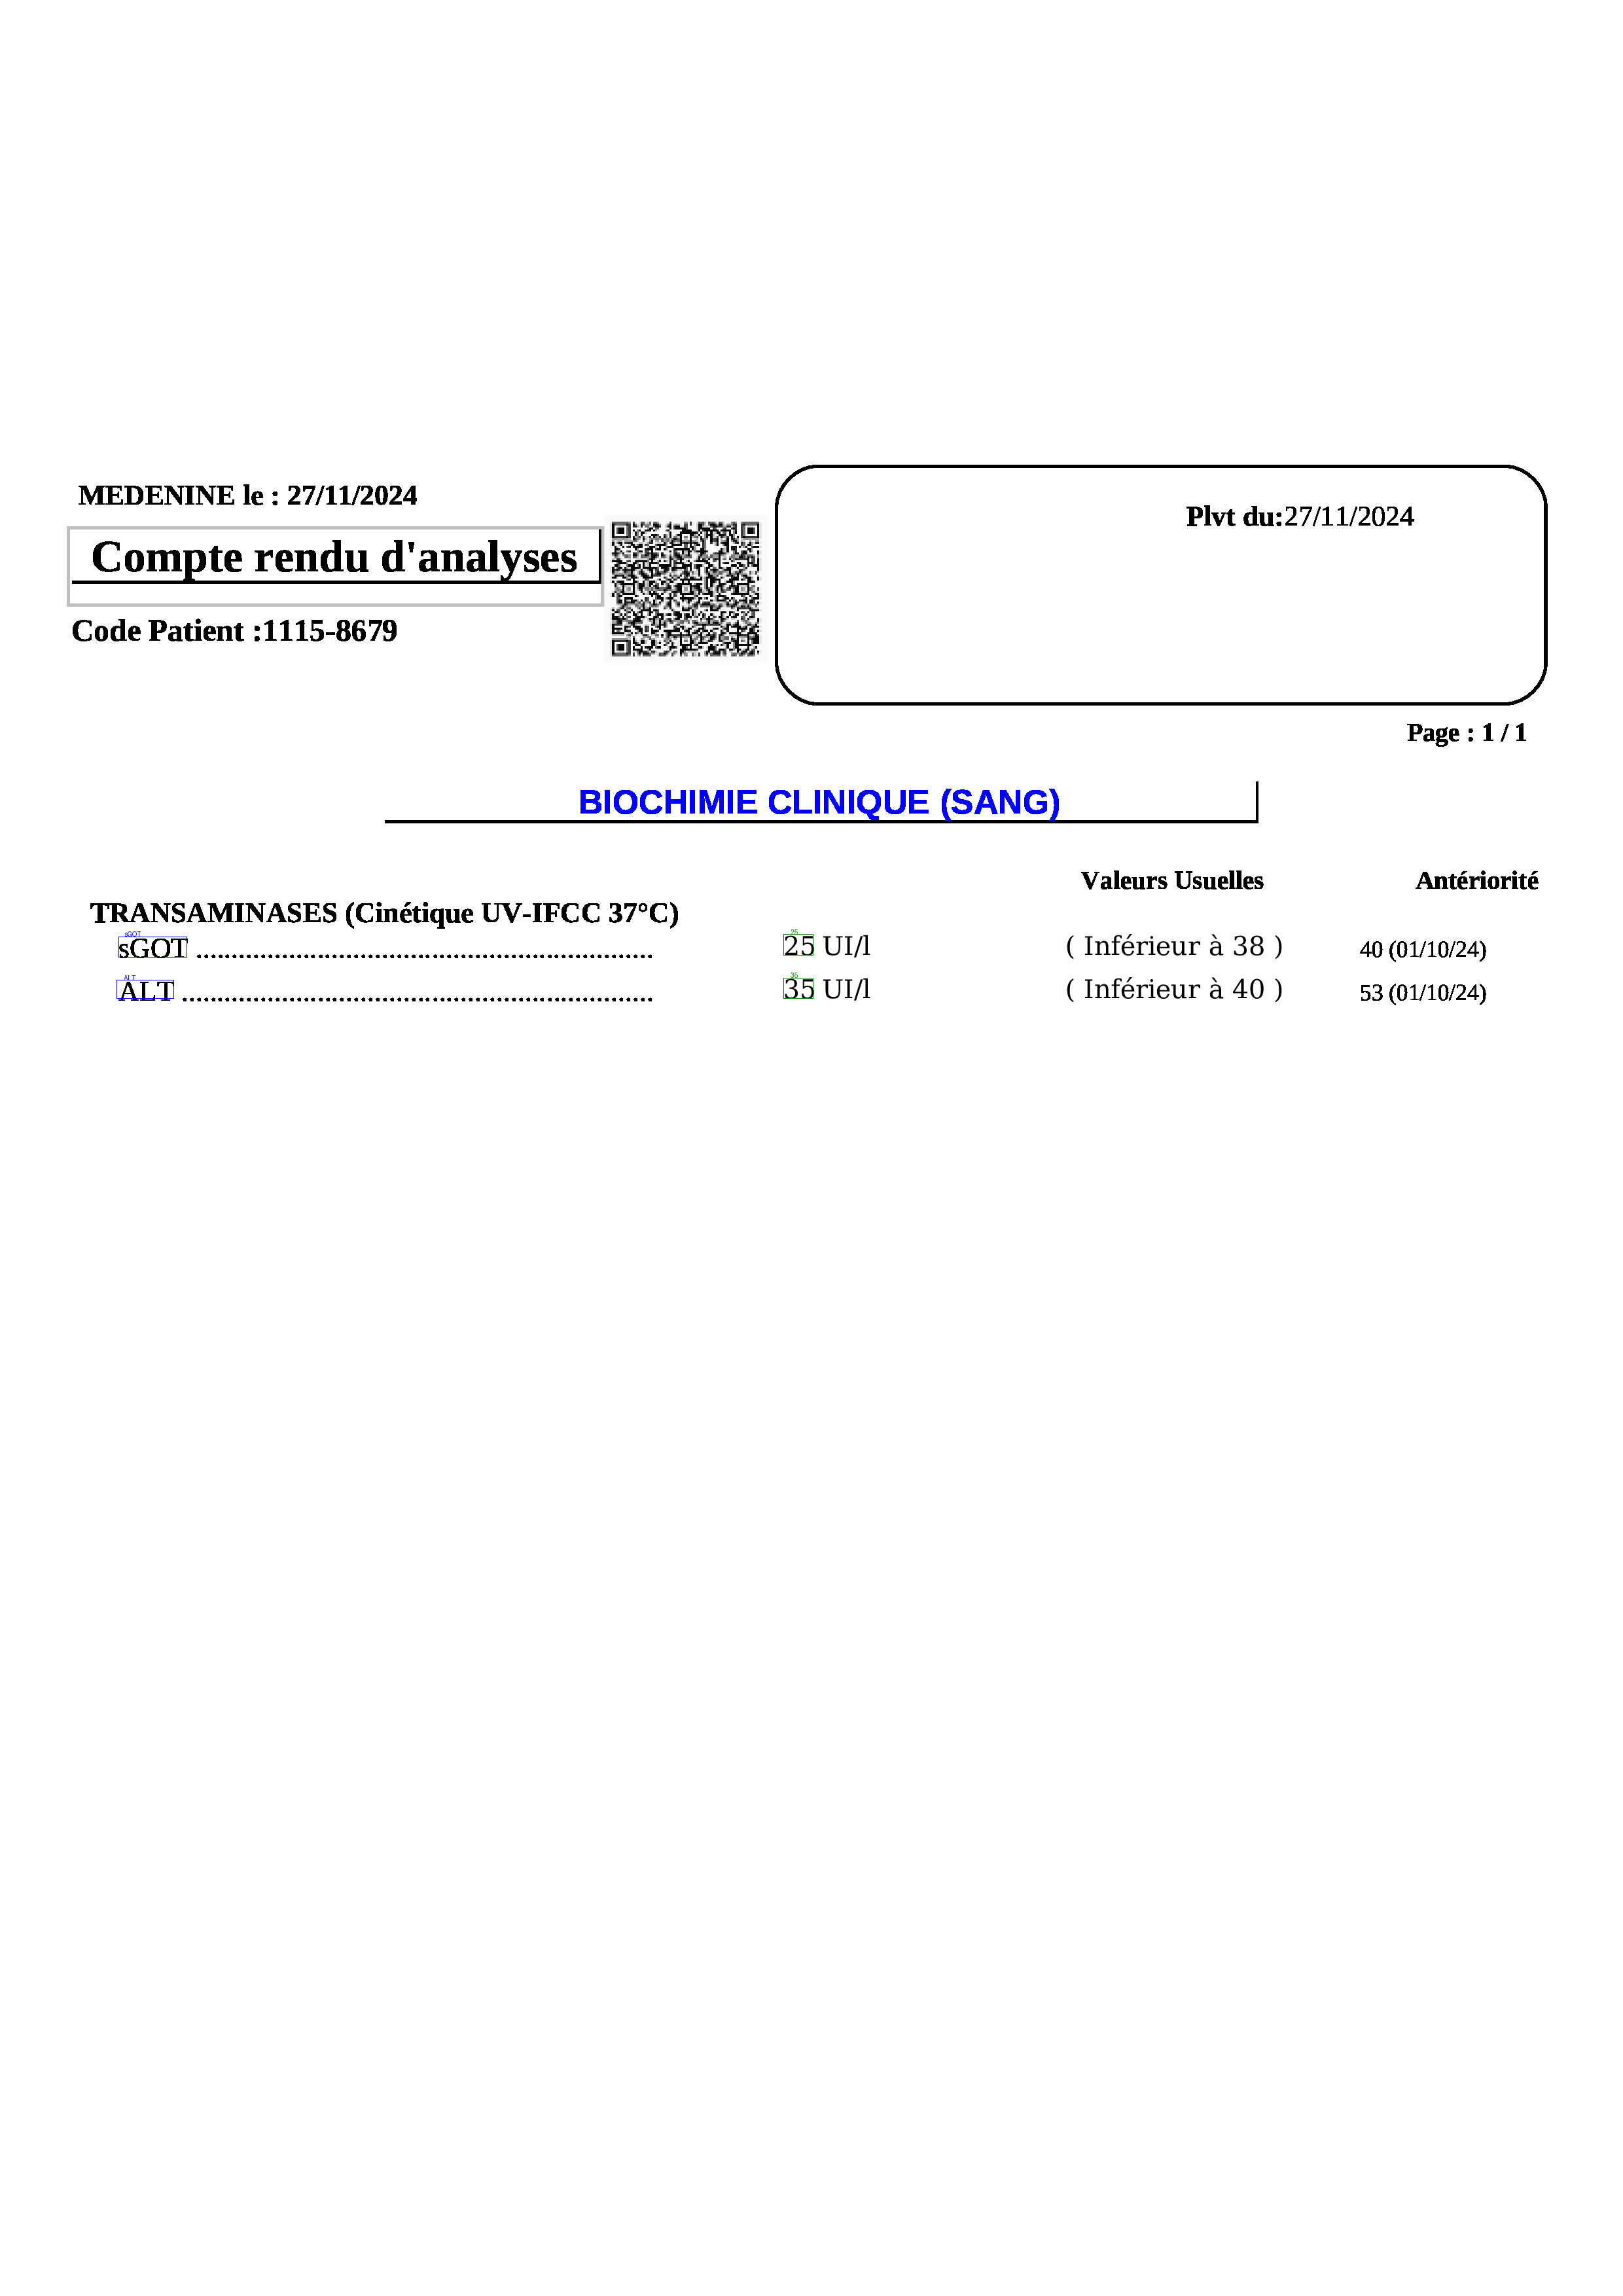

In [8]:
image_path = '/content/photo_119.jpg'
output_image, extracted_data = run_inference(image_path, model=model, processor=processor)
output_image.show()
output_image


In [9]:
print(extracted_data)

{
    "sGOT": "25",
    "ALT": "35"
}
